In [1]:
import os
import tempfile
import warnings
from os.path import join as pjoin

import dask
import dask.dataframe as dd
import dask_geopandas as dgpd
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from scipy.fft import dst
import tqdm
import xarray as xr
from dask.diagnostics import ProgressBar
from rasterio.crs import CRS

from raster_tools import Raster, Vector, open_vectors, clipping, zonal
from raster_tools.dtypes import F32, U8

import matplotlib.pyplot as plt

In [2]:
# change pandas max col display
pd.set_option('display.max_columns', 500)

In [3]:
# Location for temporary storage
TMP_LOC = "/home/jake/FireLab/Project/data/temp/"
DATA_LOC = "/home/jake/FireLab/Project/data/"

STATE = "OR"

# Location of clipped DEM files
DEM_DATA_DIR = pjoin(TMP_LOC, "dem_data")

# location of feature data files
FEATURE_DIR = pjoin(DATA_LOC, "FeatureData")
EDNA_DIR = pjoin(DATA_LOC, "terrain")
MTBS_DIR = pjoin(DATA_LOC, "MTBS_Data")

mtbs_df_path = pjoin(TMP_LOC, f"{STATE}_mtbs.parquet/")
mtbs_df_temp_path = pjoin(TMP_LOC, f"{STATE}_mtbs_temp.parquet/")
checkpoint_1_path = pjoin(TMP_LOC, "check1")
checkpoint_2_path = pjoin(TMP_LOC, "check2")

PATHS = {
    "states": pjoin(EDNA_DIR, "state_borders/cb_2018_us_state_5m.shp"),
    "dem": pjoin(EDNA_DIR, "us_orig_dem/us_orig_dem/orig_dem/hdr.adf"),
    "dem_slope": pjoin(EDNA_DIR, "us_slope/us_slope/slope/hdr.adf"),
    "dem_aspect": pjoin(EDNA_DIR, "us_aspect/aspect/hdr.adf"),
    "dem_flow_acc": pjoin(EDNA_DIR, "us_flow_acc/us_flow_acc/flow_acc/hdr.adf"),
    "gm_srad": pjoin(FEATURE_DIR, "gridmet/srad_1986_2020_weekly.nc"),
    "gm_vpd": pjoin(FEATURE_DIR, "gridmet/vpd_1986_2020_weekly.nc"),
    "aw_mat": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MAT.tif"),
    "aw_mcmt": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MCMT.tif"),
    "aw_mwmt": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MWMT.tif"),
    "aw_td": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_TD.tif"),
    "dm_tmax": pjoin(FEATURE_DIR, "daymet/tmax_1986_2020.nc"),
    "dm_tmin": pjoin(FEATURE_DIR, "daymet/tmin_1986_2020.nc"),
    "biomass_afg": pjoin(
        FEATURE_DIR, "biomass/biomass_afg_1986_2020_{}.nc".format(STATE)
    ),
    "biomass_pfg": pjoin(
        FEATURE_DIR, "biomass/biomass_pfg_1986_2020_{}.nc".format(STATE)
    ),
    "landfire_fvt": pjoin(
        FEATURE_DIR, "landfire/LF2020_FVT_200_CONUS/Tif/LC20_FVT_200.tif"
    ),
    "landfire_fbfm40": pjoin(
        FEATURE_DIR, "landfire/LF2020_FBFM40_200_CONUS/Tif/LC20_F40_200.tif"
    ),
    "ndvi": pjoin(FEATURE_DIR, "ndvi/access/weekly/ndvi_1986_2020_weekavg.nc"),
    "mtbs_root": pjoin(MTBS_DIR, "MTBS_BSmosaics/"),
    "mtbs_perim": pjoin(MTBS_DIR, "mtbs_perimeter_data/mtbs_perims_DD.shp"),
}
YEARS = list(range(1986, 2021))
GM_KEYS = list(filter(lambda x: x.startswith("gm_"), PATHS))
AW_KEYS = list(filter(lambda x: x.startswith("aw_"), PATHS))
DM_KEYS = list(filter(lambda x: x.startswith("dm_"), PATHS))
BIOMASS_KEYS = list(filter(lambda x: x.startswith("biomass_"), PATHS))
LANDFIRE_KEYS = list(filter(lambda x: x.startswith("landfire_"), PATHS))
NDVI_KEYS = list(filter(lambda x: x.startswith("ndvi"), PATHS))
DEM_KEYS = list(filter(lambda x: x.startswith("dem"), PATHS))

---

#### MTBS DATASET ADD ID AND EVENT ID

In [4]:
mtbs_dask_df = dgpd.read_parquet(mtbs_df_temp_path)
mtbs_dask_df.head()

,mtbs,geometry,state,ig_date,dem,dem_slope,dem_aspect,dem_flow_acc,dm_tmax,dm_tmin,biomass_afg,biomass_pfg,gm_srad,gm_vpd,ndvi,aw_mat,aw_mcmt,aw_mwmt,aw_td,landfire_fvt,landfire_fbfm40,hillshade,year
0,2,POINT (-1830990.000 2456610.000),OR,1986-03-20,1261.0,0.559452,305.295502,0.0,-3.049677,-16.621613,165.0,891.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2967.0,102.0,76,1986
1,2,POINT (-1830960.000 2456610.000),OR,1986-03-20,1277.0,2.485488,128.388641,0.0,-3.049677,-16.621613,411.0,638.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2967.0,102.0,187,1986
2,2,POINT (-1830990.000 2456580.000),OR,1986-03-20,1409.0,10.548834,277.054626,6.0,-3.049677,-16.621613,388.0,508.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2967.0,102.0,133,1986
3,2,POINT (-1830960.000 2456580.000),OR,1986-03-20,1545.0,7.670347,30.625286,0.0,-3.049677,-16.621613,411.0,638.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2080.0,122.0,63,1986
4,2,POINT (-1830930.000 2456580.000),OR,1986-03-20,1407.0,1.268448,124.799530,43.0,-3.049677,-16.621613,379.0,492.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2123.0,122.0,181,1986


In [ ]:
mtbs_dataset = mtbs_dask_df.compute()

In [ ]:
# # adds unique id to each pixel
# mtbs_dataset.reset_index(inplace=True)
# mtbs_dataset['index'] = mtbs_dataset.index
# # rename index to unique_id
# mtbs_dataset.rename(columns={'index': 'unique_id'}, inplace=True)
# mtbs_dataset

In [ ]:
# # rewrite to parquet
# mtbs_dataset.to_parquet(mtbs_df_path)

In [ ]:
# # a function to round numeric values in a dataframe to 3 decimals (if they are > 1)
# def round_df(df):
#     columns_to_round = ['aw_mwmt', 'dm_tmax', 'dm_tmin', 'gm_srad', 'gm_vpd', 'aw_td', 'aw_mcmt', 'dem_aspect', 'dem_slope']
#     for col in columns_to_round:
#         df[col] = df[col].round(3)
#     return df

In [5]:
# load mtbs perimeters
print("Loading MTBS perimeters")
mtbs_perim = gpd.read_file(PATHS["mtbs_perim"])
mtbs_perim['Ig_Date'] = pd.to_datetime(mtbs_perim['Ig_Date'])
mtbs_perim.columns

Loading MTBS perimeters


Index(['Event_ID', 'irwinID', 'Incid_Name', 'Incid_Type', 'Map_ID', 'Map_Prog',
       'Asmnt_Type', 'BurnBndAc', 'BurnBndLat', 'BurnBndLon', 'Ig_Date',
       'Pre_ID', 'Post_ID', 'Perim_ID', 'dNBR_offst', 'dNBR_stdDv', 'NoData_T',
       'IncGreen_T', 'Low_T', 'Mod_T', 'High_T', 'Comment', 'geometry'],
      dtype='object')

In [6]:
# extract only the columns we need (Event_ID where startswith OR, Ig_Date, and geometry)
mtbs_perim = mtbs_perim[["Event_ID", "Ig_Date", "geometry"]]
mtbs_perim = mtbs_perim[mtbs_perim.Event_ID.str.startswith("OR")]
# drop rows where Ig_Date before 1986 or after 2020
mtbs_perim = mtbs_perim[mtbs_perim.Ig_Date.dt.year.between(1986, 2020)]
mtbs_perim.reset_index(drop=True, inplace=True)
len(mtbs_perim)

960

In [ ]:
# mtbs_dataset['Fire_ID'] = 'None'
# mtbs_dataset

In [ ]:
# fire_perim_geom_OR4310211883919860320 = mtbs_perim[mtbs_perim.Ig_Date.dt.year == 1986].loc[40, 'geometry']
# fire_ig_date_OR4310211883919860320 = mtbs_perim[mtbs_perim.Ig_Date.dt.year == 1986].loc[40, 'Ig_Date']
# fire_perim_geom_OR4310211883919860320

In [7]:
# convert the geometry in mtbs_dataset to lat lon
mtbs_dask_df = mtbs_dask_df.to_crs(epsg=4326)
mtbs_perim = mtbs_perim.to_crs(epsg=4326)
# mtbs_dataset = mtbs_dataset.to_crs(epsg=4326)

In [8]:
def spatial_join(partition, mtbs_perim):
    # Convert the Dask partition to a GeoDataFrame
    gdf = gpd.GeoDataFrame(partition, geometry='geometry', crs=mtbs_perim.crs)

    # Perform the spatial join
    joined = gpd.sjoin(gdf, mtbs_perim, how="inner", predicate="intersects")

    # Filter by date if needed
    joined = joined[joined['ig_date'] == joined['Ig_Date']]
    # print(joined)

    return joined

result = mtbs_dask_df.map_partitions(spatial_join, mtbs_perim, align_dataframes=False)
with ProgressBar():
    final_result = result.compute()
print(len(final_result))
final_result

[########################################] | 100% Completed | 537.88 s
52601107


,mtbs,geometry,state,ig_date,dem,dem_slope,dem_aspect,dem_flow_acc,dm_tmax,dm_tmin,biomass_afg,biomass_pfg,gm_srad,gm_vpd,ndvi,aw_mat,aw_mcmt,aw_mwmt,aw_td,landfire_fvt,landfire_fbfm40,hillshade,year,index_right,Event_ID,Ig_Date
2,2,POINT (-118.83652 43.11476),OR,1986-03-20,1409.0,10.548834,277.054626,6.0,-3.049677,-16.621613,388.0,508.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2967.0,102.0,133.0,1986,40,OR4310211883919860320,1986-03-20
3,2,POINT (-118.83616 43.11482),OR,1986-03-20,1545.0,7.670347,30.625286,0.0,-3.049677,-16.621613,411.0,638.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2080.0,122.0,63.0,1986,40,OR4310211883919860320,1986-03-20
4,2,POINT (-118.83580 43.11489),OR,1986-03-20,1407.0,1.268448,124.799530,43.0,-3.049677,-16.621613,379.0,492.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2123.0,122.0,181.0,1986,40,OR4310211883919860320,1986-03-20
5,2,POINT (-118.83544 43.11495),OR,1986-03-20,1404.0,10.215991,204.129883,0.0,-3.049677,-16.621613,407.0,432.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2967.0,102.0,224.0,1986,40,OR4310211883919860320,1986-03-20
9,2,POINT (-118.83643 43.11450),OR,1986-03-20,1672.0,15.682027,333.058197,0.0,-3.049677,-16.621613,101.0,1185.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2123.0,122.0,74.0,1986,40,OR4310211883919860320,1986-03-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425321,1,POINT (-117.20250 43.31325),OR,2020-11-05,1585.0,18.556221,103.367493,6.0,-12.428667,-21.412666,788.0,229.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2272.0,122.0,176.0,2020,940,OR4333011722220201105,2020-11-05
425324,1,POINT (-117.20423 43.31269),OR,2020-11-05,1556.0,19.018818,88.510674,0.0,-12.428667,-21.412666,467.0,487.0,83.300003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2125.0,121.0,155.0,2020,940,OR4333011722220201105,2020-11-05
425325,1,POINT (-117.20387 43.31275),OR,2020-11-05,1545.0,19.019823,86.385704,1.0,-12.428667,-21.412666,515.0,438.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2125.0,121.0,152.0,2020,940,OR4333011722220201105,2020-11-05
425326,1,POINT (-117.20350 43.31281),OR,2020-11-05,1535.0,16.645742,83.808929,46.0,-12.428667,-21.412666,583.0,453.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2123.0,122.0,144.0,2020,940,OR4333011722220201105,2020-11-05


In [ ]:
# TODO: compare final_results and mtbs_dataset to see what is missing from final_results after the spatial join

In [9]:
final_result.drop(columns=['index_right', 'Ig_Date'], inplace=True)

In [10]:
final_result.isna().sum()

mtbs                     0
geometry                 0
state                    0
ig_date                  0
dem                      4
dem_slope                1
dem_aspect               1
dem_flow_acc             4
dm_tmax            1389245
dm_tmin            1389245
biomass_afg              0
biomass_pfg              0
gm_srad                  0
gm_vpd                   0
ndvi                113985
aw_mat                   0
aw_mcmt                  0
aw_mwmt                  0
aw_td                    0
landfire_fvt             0
landfire_fbfm40          0
hillshade                1
year                     0
Event_ID                 0
dtype: int64

In [11]:
# drop null values
final_result.dropna(inplace=True)
# adds unique id to each pixel
final_result.reset_index(inplace=True)
final_result['index'] = final_result.index
# rename index to unique_id
final_result.rename(columns={'index': 'unique_id'}, inplace=True)
final_result

,unique_id,mtbs,geometry,state,ig_date,dem,dem_slope,dem_aspect,dem_flow_acc,dm_tmax,dm_tmin,biomass_afg,biomass_pfg,gm_srad,gm_vpd,ndvi,aw_mat,aw_mcmt,aw_mwmt,aw_td,landfire_fvt,landfire_fbfm40,hillshade,year,Event_ID
0,0,2,POINT (-118.83652 43.11476),OR,1986-03-20,1409.0,10.548834,277.054626,6.0,-3.049677,-16.621613,388.0,508.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2967.0,102.0,133.0,1986,OR4310211883919860320
1,1,2,POINT (-118.83616 43.11482),OR,1986-03-20,1545.0,7.670347,30.625286,0.0,-3.049677,-16.621613,411.0,638.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2080.0,122.0,63.0,1986,OR4310211883919860320
2,2,2,POINT (-118.83580 43.11489),OR,1986-03-20,1407.0,1.268448,124.799530,43.0,-3.049677,-16.621613,379.0,492.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2123.0,122.0,181.0,1986,OR4310211883919860320
3,3,2,POINT (-118.83544 43.11495),OR,1986-03-20,1404.0,10.215991,204.129883,0.0,-3.049677,-16.621613,407.0,432.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2967.0,102.0,224.0,1986,OR4310211883919860320
4,4,2,POINT (-118.83643 43.11450),OR,1986-03-20,1672.0,15.682027,333.058197,0.0,-3.049677,-16.621613,101.0,1185.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2123.0,122.0,74.0,1986,OR4310211883919860320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51097868,51097868,1,POINT (-117.20250 43.31325),OR,2020-11-05,1585.0,18.556221,103.367493,6.0,-12.428667,-21.412666,788.0,229.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2272.0,122.0,176.0,2020,OR4333011722220201105
51097869,51097869,1,POINT (-117.20423 43.31269),OR,2020-11-05,1556.0,19.018818,88.510674,0.0,-12.428667,-21.412666,467.0,487.0,83.300003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2125.0,121.0,155.0,2020,OR4333011722220201105
51097870,51097870,1,POINT (-117.20387 43.31275),OR,2020-11-05,1545.0,19.019823,86.385704,1.0,-12.428667,-21.412666,515.0,438.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2125.0,121.0,152.0,2020,OR4333011722220201105
51097871,51097871,1,POINT (-117.20350 43.31281),OR,2020-11-05,1535.0,16.645742,83.808929,46.0,-12.428667,-21.412666,583.0,453.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2123.0,122.0,144.0,2020,OR4333011722220201105


In [ ]:
# write final_result to dask so we can write to parquet
# final_result = dd.from_pandas(final_result, npartitions=100)

In [ ]:
with ProgressBar():
    final_result.to_parquet(mtbs_df_path)

In [15]:
final_result = None

In [12]:
# read and check
mtbs_dataset_final = dgpd.read_parquet(mtbs_df_path)
mtbs_dataset_final.head()

,unique_id,mtbs,geometry,state,ig_date,dem,dem_slope,dem_aspect,dem_flow_acc,dm_tmax,dm_tmin,biomass_afg,biomass_pfg,gm_srad,gm_vpd,ndvi,aw_mat,aw_mcmt,aw_mwmt,aw_td,landfire_fvt,landfire_fbfm40,hillshade,year,Event_ID
0,0,2,POINT (-118.83652 43.11476),OR,1986-03-20,1409.0,10.548834,277.054626,6.0,-3.049677,-16.621613,388.0,508.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2967.0,102.0,133.0,1986,OR4310211883919860320
1,1,2,POINT (-118.83616 43.11482),OR,1986-03-20,1545.0,7.670347,30.625286,0.0,-3.049677,-16.621613,411.0,638.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2080.0,122.0,63.0,1986,OR4310211883919860320
2,2,2,POINT (-118.83580 43.11489),OR,1986-03-20,1407.0,1.268448,124.799530,43.0,-3.049677,-16.621613,379.0,492.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2123.0,122.0,181.0,1986,OR4310211883919860320
3,3,2,POINT (-118.83544 43.11495),OR,1986-03-20,1404.0,10.215991,204.129883,0.0,-3.049677,-16.621613,407.0,432.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2967.0,102.0,224.0,1986,OR4310211883919860320
4,4,2,POINT (-118.83643 43.11450),OR,1986-03-20,1672.0,15.682027,333.058197,0.0,-3.049677,-16.621613,101.0,1185.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2123.0,122.0,74.0,1986,OR4310211883919860320


In [14]:
mtbs_dataset_final.tail()

,unique_id,mtbs,geometry,state,ig_date,dem,dem_slope,dem_aspect,dem_flow_acc,dm_tmax,dm_tmin,biomass_afg,biomass_pfg,gm_srad,gm_vpd,ndvi,aw_mat,aw_mcmt,aw_mwmt,aw_td,landfire_fvt,landfire_fbfm40,hillshade,year,Event_ID
51097868,51097868,1,POINT (-117.20250 43.31325),OR,2020-11-05,1585.0,18.556221,103.367493,6.0,-12.428667,-21.412666,788.0,229.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.4,2272.0,122.0,176.0,2020,OR4333011722220201105
51097869,51097869,1,POINT (-117.20423 43.31269),OR,2020-11-05,1556.0,19.018818,88.510674,0.0,-12.428667,-21.412666,467.0,487.0,83.300003,0.56,0.0792,9.0,-1.6,21.799999,23.4,2125.0,121.0,155.0,2020,OR4333011722220201105
51097870,51097870,1,POINT (-117.20387 43.31275),OR,2020-11-05,1545.0,19.019823,86.385704,1.0,-12.428667,-21.412666,515.0,438.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.4,2125.0,121.0,152.0,2020,OR4333011722220201105
51097871,51097871,1,POINT (-117.20350 43.31281),OR,2020-11-05,1535.0,16.645742,83.808929,46.0,-12.428667,-21.412666,583.0,453.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.4,2123.0,122.0,144.0,2020,OR4333011722220201105
51097872,51097872,1,POINT (-117.20314 43.31287),OR,2020-11-05,1528.0,15.068486,83.439735,47.0,-12.428667,-21.412666,579.0,558.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.4,2273.0,102.0,141.0,2020,OR4333011722220201105


In [16]:
with ProgressBar():
    mtbs_final_computed = mtbs_dataset_final.compute()

[########################################] | 100% Completed | 69.71 s


<Axes: >

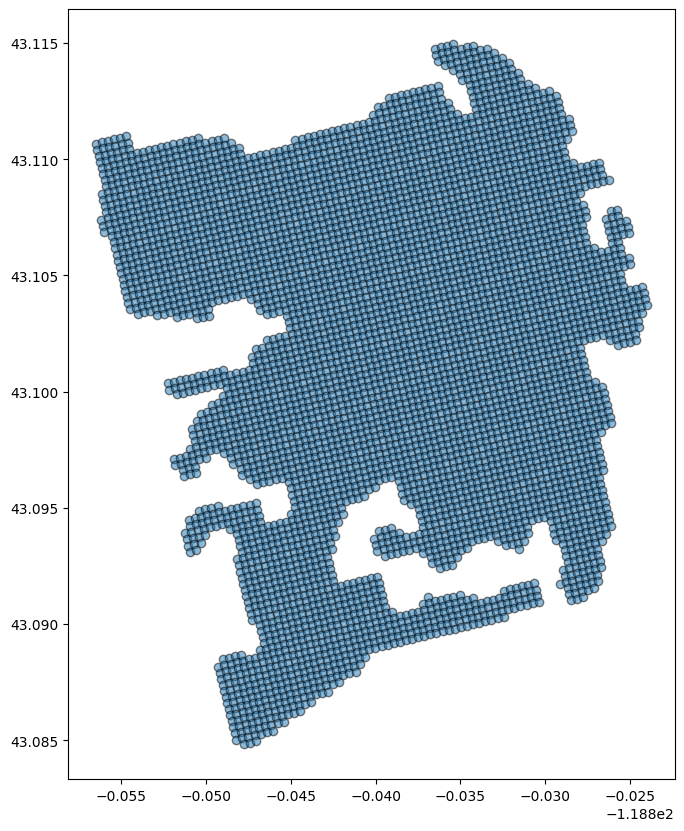

In [21]:
# plot fire with id OR4310211883919860320 with satmap background
mtbs_final_computed[mtbs_final_computed.Event_ID == 'OR4310211883919860320'].plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

In [ ]:
# get a ignition point from a fire in mtbs_dataset
fire_point_geom_OR4310211883919860320= mtbs_dataset.loc[12, 'geometry']
# dataset_fire_ig_date_OR4310211883919860320 = mtbs_dataset.loc[5, 'ig_date']

# see if the point is within any perimeter from mtbs_perim
mtbs_perim[(mtbs_perim.geometry.intersects(fire_point_geom_OR4310211883919860320))]

In [ ]:
# # write mtbs_dataset to dask dataframe
# mtbs_dataset['geometry'] = mtbs_dataset['geometry'].apply(lambda geom: geom.wkt)
# dask_mtbs_dataset = dgpd.from_geopandas(mtbs_dataset, npartitions=100)
# dask_mtbs_dataset = dask_mtbs_dataset.repartition(partition_size="100MB")
# with ProgressBar():
#     dask_mtbs_dataset.to_parquet(mtbs_df_path, engine="pyarrow")

#### Data info
---

In [ ]:
mtbs_data_fixed = dgpd.read_parquet(mtbs_df_path)
mtbs_data_fixed.head()

In [ ]:
# read from mtbs_df_path
mtbs_data = dgpd.read_parquet(mtbs_df_temp_path)
mtbs_data.head()

In [ ]:
with ProgressBar():
    mtbs_full = mtbs_dataset.compute()